In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import poisson
import numpy as np
import pickle
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [2]:
carpetas_ruido= os.listdir('clase3/ruidos ventanas')
carpetas_posta= os.listdir('clase3/medir ventanas')
df_ruido=pd.read_csv('resultados_medias_desviaciones.csv')

In [3]:
def convertir_a_segundos(texto):
    # Dividir el texto en número y unidad
    partes = texto.split()
    numero = float(partes[0])
    unidad = partes[1]

    # Convertir a segundos según la unidad
    if unidad == 'ms':
        return numero / 1000.0
    elif unidad == 'mus':
        return numero / 1_000_000.0
    else:
        raise ValueError(f"Unidad no reconocida: {unidad}")


In [4]:
def visualizar(a,m,b):
    sigr = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Desviación Estándar'].values[0]
    media = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Media'].values[0]
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/medir ventanas/{carpetas_posta[a]}'
    archivo = os.listdir(carpeta)
    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivo[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        umbral = media + a * sigr
        p = find_peaks(v, height=umbral, threshold=None, distance=None, prominence=0.01, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        return t, v, p, umbral
    for i in range(len(archivo)):
        t, v, p, umbral_valor = f(i,m)
        plt.plot(t,v,color='black')
        plt.scatter(t[p[0]], v[p[0]], color='blue')    
    plt.axhline(y=umbral_valor, color='r', linestyle='-')
    # Configurar título y etiquetas
    # plt.title(f'Superposición de v vs. t para {carpetas_posta[a]} con umbral {umbral_valor}')
    plt.xlabel('Tiempo (t)')
    plt.ylabel('Voltaje (V)')
    plt.savefig(f'Graficos posta/{carpetas_posta[a]} sigma x {m}.jpg')


def procesar(a,m):
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/medir ventanas/{carpetas_posta[a]}'
    archivo = os.listdir(carpeta)
    ventana=convertir_a_segundos(carpetas_posta[a])
    sigr = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Desviación Estándar'].values[0]
    media = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Media'].values[0]
    umbral = media + a * sigr
    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivo[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        if ventana < 0.00009:
            p = find_peaks(v, height=umbral, threshold=None, distance=20, prominence=0.009, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        else:
            if ventana == 0.00025 or ventana==0.0005:
                p=find_peaks(v, height=umbral, threshold=None, distance=10, prominence=0.009, width=None, wlen=None, rel_height=0.5, plateau_size=None)
            else:
                p=find_peaks(v, height=umbral, threshold=None, distance=8, prominence=0.009, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        return t, v, p, umbral
    picos=[]
    for i in range(len(archivo)):
        t, v, p, umbral_valor = f(i,m)
        picos.append(len(p[0]))
    # max_val = 100
    # bins = np.arange(-0.5, max_val + 0.5, 1)  # Bins centrados en enteros del 45 al 55
    # counts, bin_edges = np.histogram(picos, bins=bins, density=True)
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mu = float(np.mean(picos))
    error=np.std(picos)/np.sqrt(len(archivo))
    return ventana,mu,error



def histograma(a,b):
    m=0
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/medir ventanas/{carpetas_posta[a]}'
    archivos = os.listdir(carpeta)
    todos_los_picos = []

    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivos[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        umbral = np.mean(v) + a * np.std(v)  # Usando desviación estándar para sigr
        p = find_peaks(v, height=umbral, prominence=0.009)
        return v

    # Iterar sobre todos los archivos y recolectar picos
    for i in range(len(archivos)):
        picos = f(i, m)
        todos_los_picos.extend(picos)

    # Crear un histograma con todos los picos recolectados
    plt.hist(todos_los_picos, bins=b,log=True,label='Señal')
    plt.title(f'Histograma de voltaje (Escala Logarítmica) - Carpeta: {carpetas_posta[a]}')    
    plt.xlabel('voltaje[V]')
    plt.ylabel('Frecuencia')

In [229]:
def graficos(m):
    ventana = []
    mu = []
    error = []
    for i in range(len(carpetas_posta)):
        ventana_, mu_, error_ = procesar(i, m)
        ventana.append(ventana_)
        mu.append(mu_)
        error.append(error_)
    return ventana, mu, error

# Inicializar un diccionario para almacenar los DataFrames
dataframes = {}

# Iterar sobre los valores de m de 3 a 8
for m in range(6,7):
    # Llamar a la función graficos para cada valor de m
    ventana, mu, error = graficos(m)
    
    # Crear un DataFrame con las listas generadas
    df = pd.DataFrame({
        'ventana': ventana,
        'media': mu,
        'error': error
    })
    
    # Guardar el DataFrame en el diccionario con la clave 'm'
    dataframes[m] = df

In [32]:
with open('dataframes posta.pkl', 'rb') as file:
    data = pickle.load(file)

# 'data' ahora contiene el objeto deserializado desde el archivo pickle

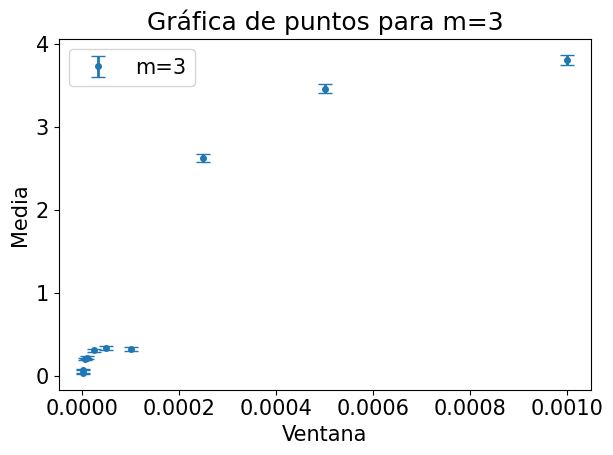

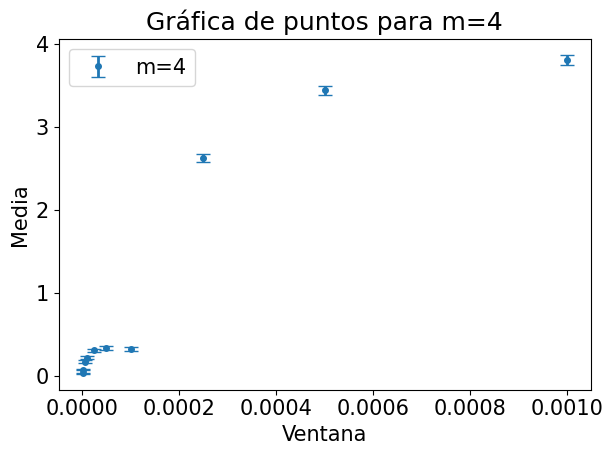

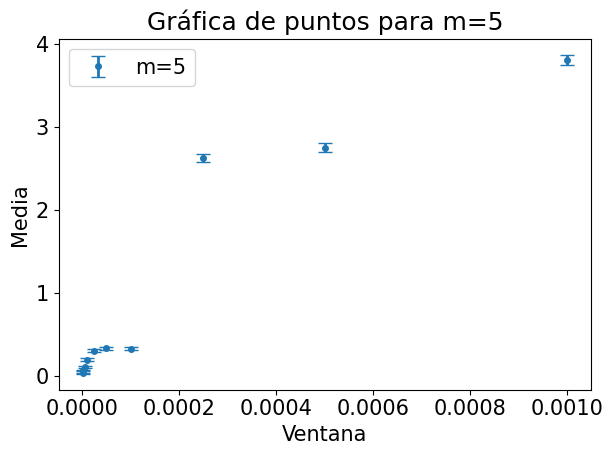

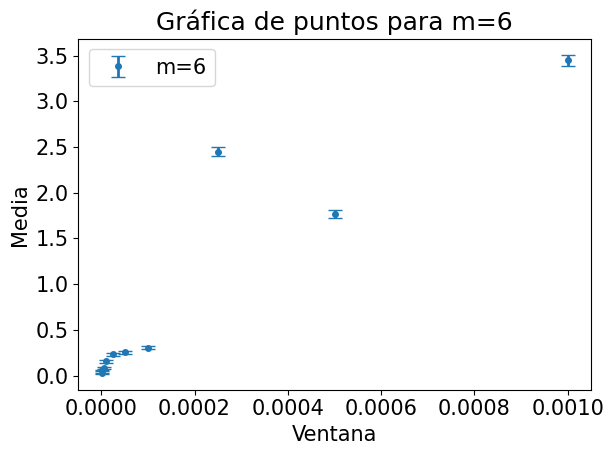

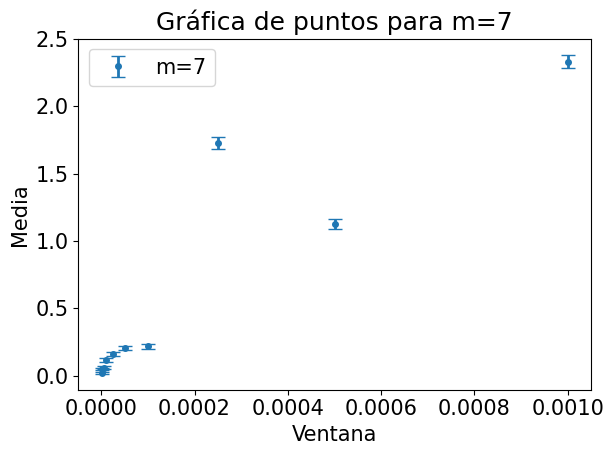

In [54]:
for m in range(3,8):
    # Filtrar el DataFrame para obtener solo las filas donde 'ventana' es menor a 0.0004
    df_filtered = data[m][data[m]['ventana'] < 5]
    
    # Graficar los puntos filtrados
    plt.errorbar(df_filtered['ventana'], df_filtered['media'], yerr=df_filtered['error'], 
                 capsize=5, fmt='o', label=f'm={m}')
    
    # Configurar la gráfica
    plt.xlabel('Ventana')
    plt.ylabel('Media')
    plt.title(f'Gráfica de puntos para m={m}')
    plt.legend()
    
    # Mostrar la gráfica
    plt.show()


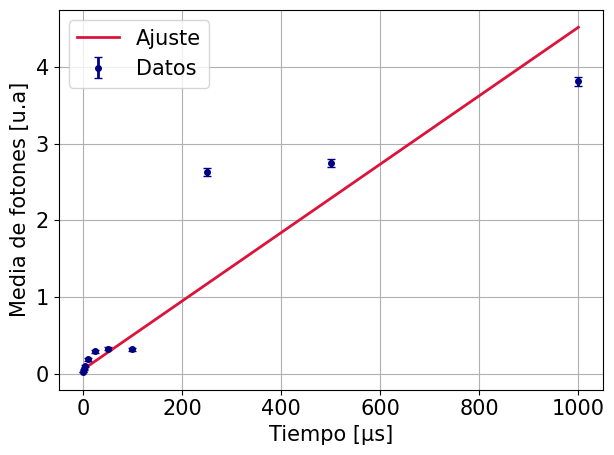

In [56]:
import likefit
def fit_model(x: np.array, par: np.array) -> np.array:
    return par[0] + par[1] * x
df_filtered = data[5][data[5]['ventana'] <8]
fitter = likefit.LinearLeastSquares(np.array(df_filtered['ventana']),np.array( df_filtered['media']),fit_model,df_filtered['error'])
fit_status = fitter.fit()
# print(fitter.pvalue())
params=fitter.get_estimators()
# fitter.plot_fit()
def f(x,a,b):
    return a*x+b
x=np.linspace(min(df_filtered['ventana']),max(df_filtered['ventana']),100)
plt.errorbar(np.array(df_filtered['ventana'])*10**6,np.array( df_filtered['media']),yerr=df_filtered['error'],fmt='o',zorder=2,color='navy',label='Datos')
plt.plot(x*10**6,f(x,params[1],params[0]),color='crimson',label='Ajuste')
plt.grid()
plt.xlabel('Tiempo [μs]')
plt.ylabel('Media de fotones [u.a]')
plt.legend()
# plt.savefig('Ajuste lineal.png')

In [171]:
dataframes[5]

,ventana,media,error
0,0.000003,0.063830,0.008914
1,0.000001,0.028786,0.005915
2,0.001000,3.682500,0.057546
3,0.000250,2.561404,0.049120
4,0.000500,2.685857,0.052449
5,0.000010,0.193467,0.015499
6,0.000050,0.328264,0.019634
7,0.000005,0.103539,0.011337
8,0.000100,0.322904,0.019336
9,0.000025,0.299242,0.018901


In [26]:
def histograma(a,b):
    m=0
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/medir ventanas/{carpetas_posta[a]}'
    archivos = os.listdir(carpeta)
    todos_los_picos = []

    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivos[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        umbral = np.mean(v) + 0* np.std(v)  # Usando desviación estándar para sigr
        p = find_peaks(v, height=umbral, prominence=0.009,distance=20)[0]
        return v

    # Iterar sobre todos los archivos y recolectar picos
    for i in range(len(archivos)):
        picos = f(i, m)
        todos_los_picos.extend(picos)

    # Crear un histograma con todos los picos recolectados
    plt.hist(todos_los_picos, bins=b,log=True,label='Señal',density=True,color='navy')
    plt.xlabel('Voltaje[V]')
    plt.ylabel('Frecuencia [u.a]')
def histograma_ruido(a,b):
    m=0
    indice = carpetas_ruido.index(carpetas_posta[a])
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/ruidos ventanas/{carpetas_ruido[indice]}'
    archivos = os.listdir(carpeta)
    todos_los_picos = []

    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivos[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        umbral = np.mean(v) + a * np.std(v)  # Usando desviación estándar para sigr
        # p = find_peaks(v, height=umbral, prominence=0.009)
        return v

    # Iterar sobre todos los archivos y recolectar picos
    for i in range(len(archivos)):
        picos = f(i, m)
        todos_los_picos.extend(picos)

    # Crear un histograma con todos los picos recolectados
    plt.hist(todos_los_picos, bins=b,log=True,label='Ruido',density=True,color='crimson')
    # plt.title(f'Histograma de voltaje (Escala Logarítmica) - Carpeta: {carpetas_posta[a]}')    



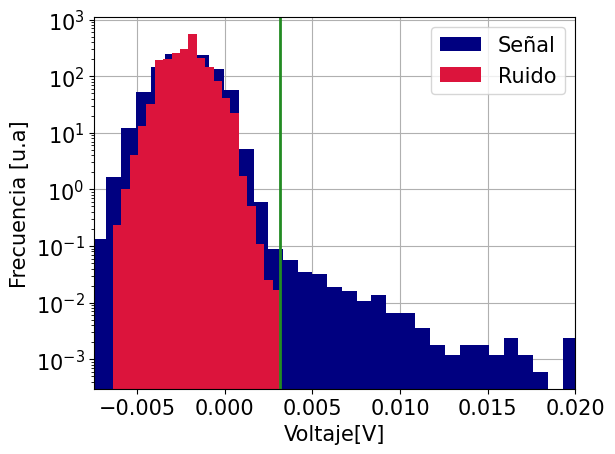

In [30]:
i=5
histograma(i,50)
histograma_ruido(i,20)
sigr = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[i], 'Desviación Estándar'].values[0]
media = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[i], 'Media'].values[0]
plt.axvline(x=media + 5*sigr, color='forestgreen', linestyle='-')
plt.legend()
plt.grid()
plt.xlim(media - 5*sigr,0.02)
# plt.xlim(media,media+10*sigr)
plt.savefig(f'Histograma {carpetas_posta[i]}.png')
plt.show()
    


In [134]:
def visualizar(a,m,b):
    sigr = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Desviación Estándar'].values[0]
    media = df_ruido.loc[df_ruido['Carpeta'] == carpetas_posta[a], 'Media'].values[0]
    carpeta = f'/home/luciano/Escritorio/Labo 5/datos/medir ventanas/{carpetas_posta[a]}'
    archivo = os.listdir(carpeta)
    umbral = media + m * sigr
    def f(i, a):
        ruta_archivo = os.path.join(carpeta, archivo[i])
        datos = pd.read_csv(ruta_archivo)
        t = datos['t']
        v = -datos['V1']
        p = find_peaks(v, height=umbral, threshold=None, distance=75, prominence=0.01, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        return t, v, p, umbral
    for i in range(len(archivo)):
        t, v, p, umbral_valor = f(i,m)
        plt.plot(t,v,color='black')
        plt.axhline(y=umbral_valor, color='r', linestyle='-')
        plt.scatter(t[p[0]], v[p[0]],label=f'{archivo[i]}')
        plt.show()
    # plt.axhline(y=umbral_valor, color='r', linestyle='-')
    # # Configurar título y etiquetas
    # # plt.title(f'Superposición de v vs. t para {carpetas_posta[a]} con umbral {umbral_valor}')
    # plt.xlabel('Tiempo (t)')
    # plt.ylabel('Voltaje (V)')